In [1]:
#基本的なモジュール
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, gc, re, time
import tqdm as tqdm
import warnings
pd.set_option("max_columns",None)
warnings.filterwarnings('ignore')

In [2]:
#前処理モジュール
from sklearn import preprocessing

In [3]:
#アルゴリズム・評価モジュール
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
import lightgbm as lgb
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle
import time
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
#別のnotebookで前処理したもの
add_data = pd.read_csv("land_price.csv")

# head

In [5]:
train.head(2)

,id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Renovation,Remarks,y
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,1,２ＬＤＫ,55,NaN,NaN,NaN,昭和59年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,600.0,2017年第４四半期,改装済,NaN,66.0
1,2,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,5,１Ｋ,20,NaN,NaN,NaN,平成15年,ＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,500.0,2017年第４四半期,未改装,NaN,19.0


In [6]:
test.head(2)

,id,Type,Region,MunicipalityCode,Prefecture,Municipality,DistrictName,NearestStation,TimeToNearestStation,FloorPlan,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,Structure,Use,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Period,Renovation,Remarks
0,1,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,3,１ＬＤＫ,35,NaN,NaN,NaN,昭和60年,ＳＲＣ,住宅,住宅,NaN,NaN,NaN,商業地域,80.0,700.0,2018年第４四半期,未改装,NaN
1,2,中古マンション等,NaN,13101,東京都,千代田区,飯田橋,飯田橋,4,１Ｋ,20,NaN,NaN,NaN,昭和57年,ＳＲＣ,NaN,住宅,NaN,NaN,NaN,商業地域,80.0,700.0,2018年第３四半期,未改装,NaN


# 前処理

# データマージ

In [7]:
add_data = add_data[["Adress","H31_Price"]]
add_data = add_data.groupby("Adress")["H31_Price"].mean().reset_index()

In [8]:
train["Adress"] = train["Municipality"]+train["DistrictName"].fillna("")
train = pd.merge(train, add_data, on="Adress", how="left")
test["Adress"] = test["Municipality"]+test["DistrictName"].fillna("")
test = pd.merge(test, add_data, on="Adress", how="left")

### category_process

In [9]:
for data in [train,test]:
    data[["year","quarter"]] = data["Period"].str.split("年",expand=True)

In [10]:
#cat変数
for col in ['Type', 'Municipality', 'quarter', 'DistrictName', 'NearestStation', 'CityPlanning', 'Region', 'LandShape',
            'Purpose', 'Direction', 'Classification', 'Renovation']:
    train[col] = train[col].fillna("N")
    test[col] = test[col].fillna("N")
    all_data = pd.concat([train[col], test[col]], axis=0, ignore_index=True).reset_index(drop=True)
    le = preprocessing.LabelEncoder()
    le.fit(all_data)
    train[col] = le.transform(train[col])
    test[col] = le.transform(test[col])
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

### numerical

In [11]:
#とりあえず適当な値で埋める(欠損値はそのまま)
for data in [train,test]:
    #Area
    data.loc[data["Area"] == '2000㎡以上',"Area"] = '2100'
    data.loc[data["Area"] == '5000㎡以上',"Area"] = '5100'
    data["Area"] = data["Area"].astype(int)
    #TimeToNearestStation
    data.loc[data["TimeToNearestStation"] == '30分?60分',"TimeToNearestStation"] = 60
    data.loc[data["TimeToNearestStation"] == '1H?1H30',"TimeToNearestStation"] = 90
    data.loc[data["TimeToNearestStation"] == '1H30?2H',"TimeToNearestStation"] = 105
    data.loc[data["TimeToNearestStation"] == '2H?',"TimeToNearestStation"] = 120
    data.loc[data["TimeToNearestStation"].isnull() == True,"TimeToNearestStation"] = 1000
    data["TimeToNearestStation"] = data["TimeToNearestStation"].astype(int)
    data.loc[data["TimeToNearestStation"] == 1000,"TimeToNearestStation"] = np.nan
    #BuildingYear
    data["BuildingYear"] = data["BuildingYear"].fillna("昭和10年")
    data["BuildingYear"] = data["BuildingYear"].apply(lambda x: re.sub("戦前","昭和20年",x))
    data["syouwa_flag"] = data["BuildingYear"].apply(lambda x: 1 if "昭和" in x else 0)
    data["BuildingYear"] = data["BuildingYear"].apply(lambda x: re.sub("年|平成|昭和","",x))
    data["BuildingYear"] = data["BuildingYear"].astype(int)
    data.loc[data["syouwa_flag"] == 1,"BuildingYear"] -= 63
    data.loc[data["BuildingYear"] == -53,"BuildingYear"] = np.nan

In [12]:
for data in [train,test]:
    #'FrontageTotal
    data.loc[data["Frontage"] == '50.0m以上', "Frontage"] = 55
    data.loc[data["Frontage"].isnull() == True, "Frontage"] = np.nan
    data["Frontage"] = data["Frontage"].astype(float)
    #TotalFloorArea
    data.loc[data["TotalFloorArea"] == '10m^2未満', "TotalFloorArea"] = 5
    data.loc[data["TotalFloorArea"] == '2000㎡以上', "TotalFloorArea"] = 2000
    data.loc[data["TotalFloorArea"].isnull() == True, "TotalFloorArea"] = np.nan
    data["TotalFloorArea"] = data["TotalFloorArea"].astype(float)

In [13]:
#feature_engineering
for data in [train,test]:
    data["log_price"] = np.log(data["Area"]*data["H31_Price"])
    data["H31_Price"] = np.log(data["H31_Price"])

# 訓練に突っ込むための処理

In [14]:
drop_col = ["id","MunicipalityCode","Prefecture","FloorPlan","Remarks","Structure","Use","Period","year","syouwa_flag","Adress"]
test_id = test["id"]
target = train["y"]
train.drop(drop_col, axis=1, inplace=True)
train.drop("y", axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)
columns = train.columns

In [15]:
train.head()

,Type,Region,Municipality,DistrictName,NearestStation,TimeToNearestStation,Area,LandShape,Frontage,TotalFloorArea,BuildingYear,Purpose,Direction,Classification,Breadth,CityPlanning,CoverageRatio,FloorAreaRatio,Renovation,H31_Price,quarter,log_price
0,0,0,9,1404,628,1.0,55,0,NaN,NaN,-4.0,3,0,0,NaN,1,80.0,600.0,1,15.142586,3,19.149919
1,0,0,9,1404,628,5.0,20,0,NaN,NaN,15.0,3,0,0,NaN,1,80.0,500.0,2,15.142586,3,18.138318
2,0,0,9,1404,628,3.0,45,0,NaN,NaN,24.0,1,0,0,NaN,1,80.0,500.0,2,15.142586,2,18.949248
3,0,0,9,1404,628,5.0,20,0,NaN,NaN,15.0,3,0,0,NaN,1,80.0,500.0,2,15.142586,2,18.138318
4,2,2,9,1404,628,3.0,80,1,6.8,330.0,-2.0,2,6,2,8.0,1,80.0,500.0,0,15.142586,1,19.524612


# 分析

In [16]:
#regression
params = {'objective': 'regression',
          'metric':'rmse',
          'max_depth': -1,
          'learning_rate': 0.01,
          "verbosity": 100,
          'seed': 777
         }

In [17]:
NFOLDS = 6
folds = KFold(n_splits=NFOLDS, random_state=777)

#columns = feature
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(train.shape[0])
score = 0

feature_importance = pd.DataFrame()

feature_importance['feature'] = columns

start = time.time()
y_preds = np.zeros(test.shape[0])
y_oof = np.zeros(train.shape[0])
score = 0
splits = folds.split(train, target)
    
for fold_n, (train_index, valid_index) in enumerate(splits):
    fold_start = time.time()
    lg_train = lgb.Dataset(train.loc[train_index], label=target[train_index])
    lg_test = lgb.Dataset(train.loc[valid_index], label=target[valid_index])
    model = lgb.train(params, lg_train, 20000, valid_sets = [lg_train, lg_test], verbose_eval=500, early_stopping_rounds=500)
    va_pred = model.predict(train.loc[valid_index])
    va_target = target[valid_index]
    feature_importance[f'fold_{fold_n + 1}'] = model.feature_importance()
        
    print(f"Fold {fold_n + 1} | RMSE: {np.sqrt(mean_squared_error(va_pred, va_target))}")
        
    score += np.sqrt(mean_squared_error(va_pred, va_target)) / NFOLDS
    #y_preds += clf.predict(test) / NFOLDS
    y_oof[valid_index] = va_pred
    print("{:2.0f}分{:2.0f}秒".format((time.time()-fold_start)//60,(time.time()-fold_start)%60))
        
print("合計")
print("{:2.0f}分{:2.0f}秒".format((time.time()-start)//60,(time.time()-start)%60))
    

print(f"\nMean RMSE = {score}")
print(f"Out of folds RMSE = {np.sqrt(mean_squared_error(y_oof, target))}")
print()

Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 130.526	valid_1's rmse: 274.57
[1000]	training's rmse: 94.556	valid_1's rmse: 272.698
[1500]	training's rmse: 75.8149	valid_1's rmse: 271.228
Early stopping, best iteration is:
[1335]	training's rmse: 80.9521	valid_1's rmse: 271.186
Fold 1 | RMSE: 271.1863989154357
 0分11秒
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 135.386	valid_1's rmse: 308.589
[1000]	training's rmse: 109.661	valid_1's rmse: 305.712
[1500]	training's rmse: 95.1447	valid_1's rmse: 307.93
Early stopping, best iteration is:
[1003]	training's rmse: 109.568	valid_1's rmse: 305.698
Fold 2 | RMSE: 305.697717951832
 0分 8秒
Training until validation scores don't improve for 500 rounds
[500]	training's rmse: 149.561	valid_1's rmse: 174.158
Early stopping, best iteration is:
[282]	training's rmse: 186.216	valid_1's rmse: 172.56
Fold 3 | RMSE: 172.5596952642943
 0分 5秒
Training until validation scores don't

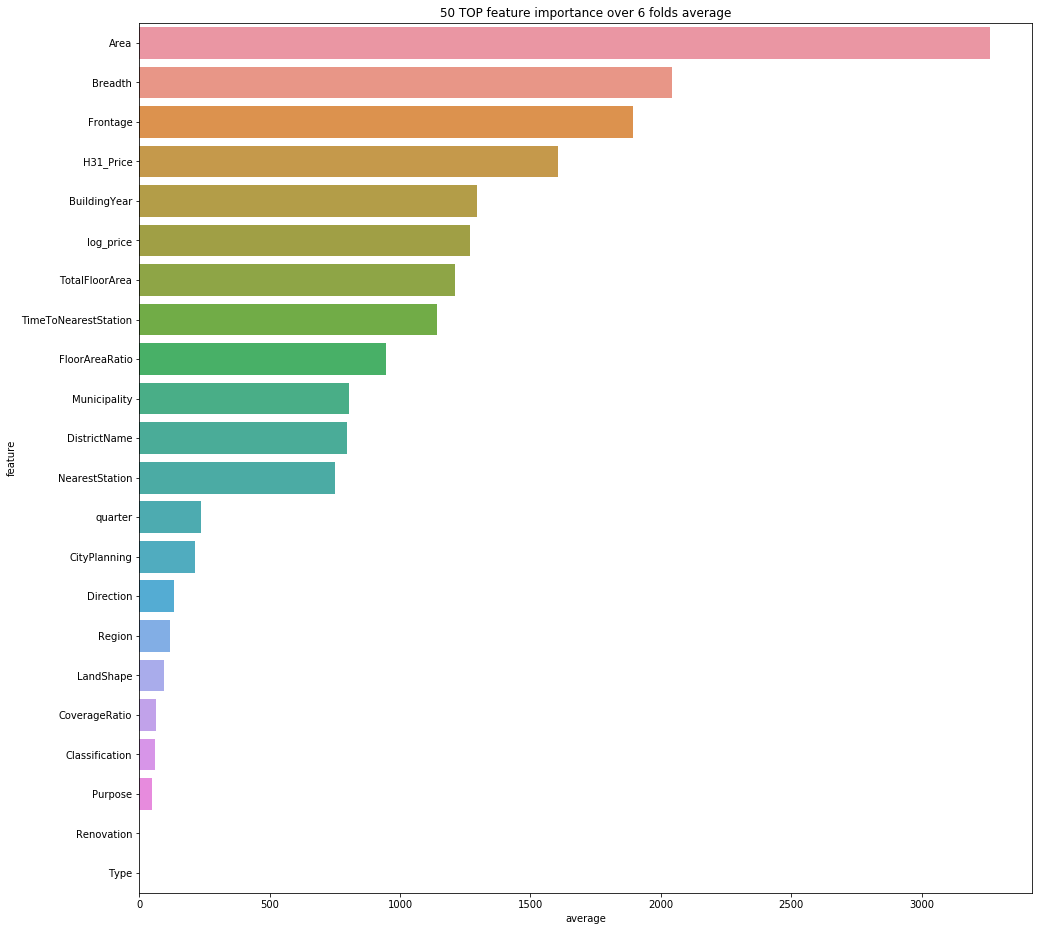

In [18]:
feature_importance['average'] = feature_importance[[f'fold_{fold_n + 1}' for fold_n in range(folds.n_splits)]].mean(axis=1)
feature_importance.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importance.sort_values(by='average', ascending=False), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

# 全体を通して予測

In [19]:
submit = pd.DataFrame()
submit["id"] = test_id

In [20]:
lg_train = lgb.Dataset(train, label=target)
lg = lgb.train(params, lg_train, 1400)

In [21]:
predict = lg.predict(test)

In [22]:
submit["y"] = predict
submit.to_csv("PB.csv",index=None)